# Task 6: Drive to Coordinates Using the PID Controller

In this notebook, we want to use a PID controller to drive to a given point. We have provided you with a class that simulates (at least to some degree) the movement of a two wheeled robot and can be used to test your implementation. Please note that it will still behave significantly diffent from yor actual robot, and that the parameters for PID might be very different.

## Imports

In [1]:
import numpy as np

import sys
import os
sys.path.insert(1, os.path.join(os.getcwd(), '..'))

#from utils.utils import difference_angle
from matplotlib import pyplot as plt
import matplotlib
import math
from utils.utils import PIDController
from utils.EKFSLAM import EKFSLAM
from utils.robot_dummy import DummyVehicle
from utils.utils import load_config
def difference_angle(angle1, angle2):
    difference = (angle1 - angle2) % (2*np.pi)
    difference = np.where(difference > np.pi, difference - 2*np.pi, difference)
    difference = difference.item()
    return difference


/home/pi/robotics-project-2024/robot-code/notebooks


/home/pi/.ev3-venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Robot Setup

For this notebook, we provide you with a simple simulated robot. Its behaviour is similar to that of the actual robot, so you can use it to test your implementation. Be aware however that transfering the *drive_to_point* function you will implement in this notebook to your actual robot will likely still require extensive tuning!

In [2]:
config = load_config("../config.yaml")
# init robot
robot = DummyVehicle(0.0, 0.0, 0.0, config.robot.wheel_radius, config.robot.width, 0.1, 0.01, np.pi/4)

config:
{
    'robot': {'wheel_radius': 0.027216, 'width': 0.15, 'delta_t': 0.15},
    'camera': {'y_offset': -0.05, 'z_offset': 0.27, 'x_angle': -131, 'exposure_time': 80, 'gain': 50},
    'ekf_slam': {'robot_width': 0.15, 'motor_std': 4, 'dist_std': 0.1, 'angle_std': 4},
    'pid_controller': {'P': 100, 'I': 0, 'D': 0}
}

To give you a bit of a feeling for how our simulated robot moves, we have provided a few example steps. Feel free to change both the robot parameters and the inputs to the move function. The move function takes the same inputs as the move function on the actual robot and should act similarly.

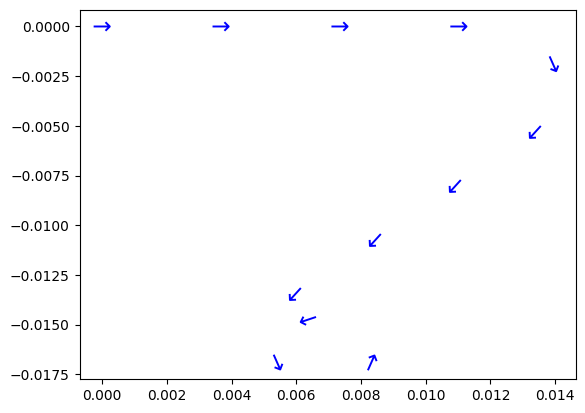

In [3]:
steps = [[10, 0], [10,0], [10,0], [10, 40], [10,40], [10, 0], [10,0], [10, 0], [10, -40], [10, -80], [10, -80]]

xs = [0]
ys = [0]
thetas = [0]
for s in steps:
    speed, turn = s
    robot.move(speed, turn)
    
    xs.append(robot.x)
    ys.append(robot.y)
    thetas.append(robot.theta)


arrow = u'$\u2191$'
for x,y,theta in zip(xs,ys,thetas):
    rotated_marker = matplotlib.markers.MarkerStyle(marker=arrow)
    rotated_marker._transform = rotated_marker.get_transform().rotate_deg(math.degrees(theta)-90)
    plt.scatter((x), (y), marker=rotated_marker, s=150, facecolors='b', edgecolors='none')
plt.show()

## Driving to a Point

First, we set up our robot, with an initial position of (0,0), and set a position for the target point the robot is supposed to reach.

**Note:** Try different start and goal positions to make sure that your function works reliably!

In [116]:
goal_position = np.array([-2, -2])
start_x = 0.0
start_y = 0.0
start_theta = 0


robot = DummyVehicle(start_x, start_y, start_theta, config.robot.wheel_radius, config.robot.width, 0.01, 0.01, np.pi/4)

**Task:** Make the simulated robot drive to the goal position, using your PID controller implementation from *notebook 4*. For each timestep of the simulation save the robot's current position and heading (x, y, theta), and the control signal returned by your PID controller.

**Note:** You can use the *difference_angle* function to compute the heading error. 

**Note:** You can access the robot's position and heading using *robot.x*, *robot.y*, and *robot.theta*.

In [117]:
n_timesteps = 6000
def difference_angle2(angle1, angle2):
    # Calculate the angular difference with sign
    diff = np.arctan2(np.sin(angle1 - angle2), np.cos(angle1 - angle2))
    return diff
positions = []
control_signals = []
errors = []

# Adjust PID gains for smoother control
PID = PIDController(20, 0,0)  # Lower and more balanced gains

# Reduce maximum turn rate
mx_turn = 100
mx_speed = 100
angle_threshold = 0.3  # Slightly tighter threshold

for t in range(n_timesteps):
    # Calculate current distance to the goal
    current_distance = np.hypot(goal_position[0] - robot.x, goal_position[1] - robot.y)
    
    # Get the current position and heading
    current_position = [robot.x, robot.y, robot.theta]
    positions.append(current_position)
    
    # Calculate the angle to the goal
    delta_x = goal_position[0] - robot.x
    delta_y = goal_position[1] - robot.y
    angle_to_point = np.arctan2(delta_y, delta_x)
    
    # Calculate the heading error
    angle_deviation = difference_angle2(angle_to_point, robot.theta)
    
    # Get control signals from PID controller
    turn = PID.get_u(-angle_deviation)
    #turn = np.clip(turn, -mx_turn, mx_turn)
    
    # Adaptive speed based on angle deviation and distance
    speed = min(mx_speed,  current_distance *20)
    
    # Reduce speed proportionally to angle deviation
    speed *= max(0, 1 - abs(angle_deviation) / np.pi)
    
    # Stop conditions
    if current_distance < 0.01:
        speed = 0
        turn = 0
    
    # Store control signals and errors
    control_signals.append([speed, turn])
    errors.append([angle_deviation, delta_x, delta_y, speed, turn])
    #print(current_position[0],current_position[1])
    # Move the robot
    robot.move(speed, turn)

20 0 0

In [118]:
positions_array = np.array(positions)
positions_array[:,2]
errors = np.array(errors)
angles = errors[:,2]
print(len(angles))

6000


ValueError: x and y must be the same size

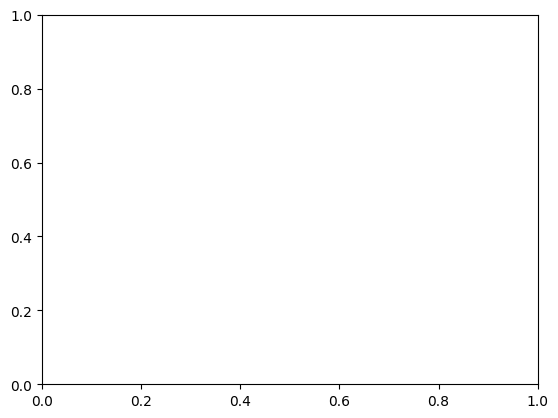

In [95]:
plt.scatter(range(6000), angles)

In [85]:
len(positions)

6000

In [87]:
positions[:][2]

[np.float64(0.0011152183665075815),
 np.float64(-0.00015636959542727848),
 np.float64(6.019062233279152)]

**Task:** Plot the heading error (*angle error*), position error, and control signal from the start point until the robot reaches its target.

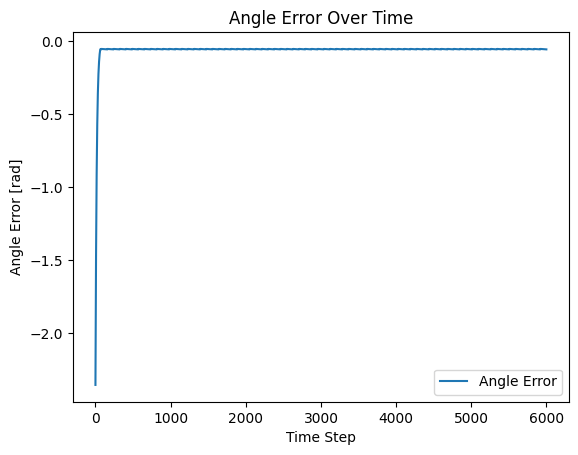

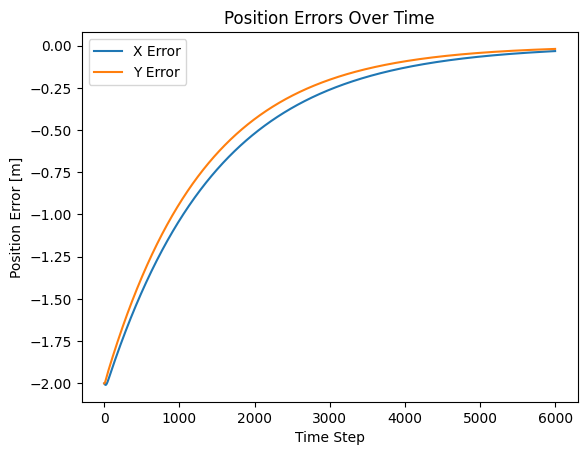

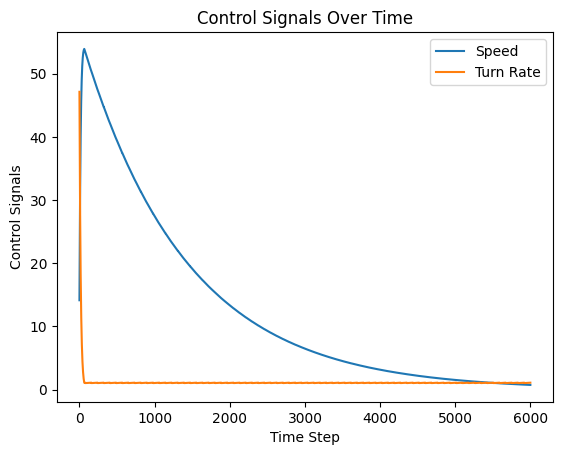

In [119]:
# Convert errors list to a NumPy array for easy indexing
errors = np.array(errors)
time_steps = np.arange(len(errors))

# Plot angle error over time
plt.figure()
plt.plot(time_steps, errors[:, 0], label='Angle Error')
plt.xlabel('Time Step')
plt.ylabel('Angle Error [rad]')
plt.title('Angle Error Over Time')
plt.legend()
plt.show()

# Plot position errors over time
plt.figure()
plt.plot(time_steps, errors[:, 1], label='X Error')
plt.plot(time_steps, errors[:, 2], label='Y Error')
plt.xlabel('Time Step')
plt.ylabel('Position Error [m]')
plt.title('Position Errors Over Time')
plt.legend()
plt.show()

# Plot control signals over time
control_signals = np.array(control_signals)
plt.figure()
plt.plot(time_steps, control_signals[:, 0], label='Speed')
plt.plot(time_steps, control_signals[:, 1], label='Turn Rate')
plt.xlabel('Time Step')
plt.ylabel('Control Signals')
plt.title('Control Signals Over Time')
plt.legend()
plt.show()


**Task:** Plot the position and heading of the robot along its paths to the target point.

0
3.9483393374931572
3.929332885603666
3.9103260017942825
3.8913186862948894
3.8723132265892124
3.8533050489479668
3.8342987250642437
3.8152919735788577
3.7962847869788927
3.777279460194262
3.7582714123330008


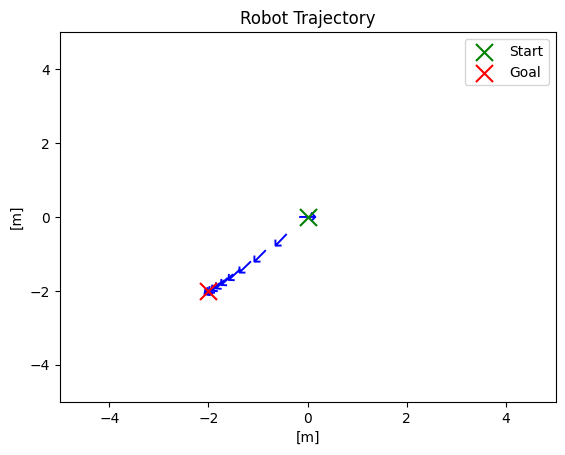

In [120]:
import matplotlib
import matplotlib.pyplot as plt

arrow = u'$\u2191$'

# Visualization parameters
visualisation_step = 500

# Plot the robot's trajectory
for idx in range(0, len(positions), visualisation_step):
    x, y, theta = positions[idx]
    if idx % 1 == 0:
        print(theta)
    rotated_marker = matplotlib.markers.MarkerStyle(marker=arrow)
    rotated_marker._transform = rotated_marker.get_transform().rotate_deg(np.degrees(theta) - 90)
    plt.scatter(x, y, marker=rotated_marker, s=150, facecolors='b', edgecolors='none')

# Mark the start and goal positions
plt.scatter([start_x], [start_y], marker="x", color="g", s=150, label='Start')
plt.scatter([goal_position[0]], [goal_position[1]], marker="x", color="r", s=150, label='Goal')

# Set plot limits and labels
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.ylabel("[m]")
plt.xlabel("[m]")
plt.legend()
plt.title("Robot Trajectory")
plt.show()


In [42]:
print(positions[2][:])


[np.float64(0.0005180256791410831), np.float64(-3.5277518333890344e-05), np.float64(6.147195387631949)]
